# Combining Active Suggestions

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from time import time
from mclearn.experiment import ActiveExperiment, load_results, save_results
from mclearn.tools import log
from sklearn.externals import joblib
from matplotlib.ticker import FuncFormatter
%matplotlib inline
sns.set_style('white')

## Experiment

Experiment Setup:

* 10-fold stratified shuffled split cross validation
* training pool size: 70% of data up to a maximum of 10,000 examples
* test pool size: the remaining examples up to a maximum of 20,000
* use logistic regression with gaussian kernel approximation and L2 loss

In [3]:
RUN_EXPERIMENTS = False
uci_sets = ['glass', 'ionosphere', 'iris', 'magic', 'miniboone',
            'pageblocks', 'pima', 'sonar', 'vehicle', 'wine', 'wpbc'] 
datasets =  sorted(uci_sets + ['sdss'])
methods =  ['passive', 'margin', 'w-margin', 'confidence',
            'w-confidence', 'entropy', 'w-entropy',
            'qbb-margin', 'qbb-kl', 'passive', 'thompson', 'ocucb', 'klucb',
            'exp++', 'borda', 'geometric', 'schulze']

In [4]:
def run_expt(X, y, dataset, scale=True):
    log(dataset, end='')
    for method in methods:
        log('.', end='')
        expt = ActiveExperiment(X, y, dataset, method, scale)
        expt.run_policies()
    
    expt = ActiveExperiment(X, y, dataset, None, scale)
    expt.run_asymptote()
    log('')

In [5]:
if RUN_EXPERIMENTS:
    for dataset in uci_sets:
        data_path = os.path.join('data', dataset + '.csv')
        data = pd.read_csv(data_path)
        X, y = data.iloc[:, 1:], data['target']
        run_expt(X, y, dataset)

    data_path = os.path.join('data', 'sdss.h5')
    data = pd.read_hdf(data_path, 'sdss')
    class_idx = data.columns.get_loc('class')
    X, y = data.iloc[:, (class_idx+1):], data['class']
    run_expt(X, y, 'sdss', False)

In [6]:
if RUN_EXPERIMENTS:
    for (i, dataset) in enumerate(datasets):
        maximum = {}
        measures = ['f1', 'accuracy', 'mpba']
        for measure in measures:
            asymptote_measure = 'asymptote_' + measure
            max_measure = 'max_' + measure
            results = {}
            for method in methods:
                results[method] = load_results(dataset, method, 'mpba', True)
            results['asymptote'] = load_results(dataset, 'asymptote', asymptote_measure, True)
            maximum[max_measure] = results['asymptote']
            for method in methods:
                maximum[max_measure] = max(maximum[max_measure], max(results[method]))
        save_results(dataset, 'max', maximum)

### No passive arm

In [ ]:
def run_expt(X, y, dataset, scale=True):
    log(dataset, end='')
    for method in methods:
        log('.', end='')
        expt = ActiveExperiment(X, y, dataset, method, scale=scale, passive=False)
        expt.run_policies()

In [ ]:
methods =  ['thompson', 'ocucb', 'klucb',
            'exp++', 'borda', 'geometric', 'schulze']

In [ ]:
if RUN_EXPERIMENTS:
    for dataset in uci_sets:
        data_path = os.path.join('data', dataset + '.csv')
        data = pd.read_csv(data_path)
        X, y = data.iloc[:, 1:], data['target']
        run_expt(X, y, dataset)

    data_path = os.path.join('data', 'sdss.h5')
    data = pd.read_hdf(data_path, 'sdss')
    class_idx = data.columns.get_loc('class')
    X, y = data.iloc[:, (class_idx+1):], data['class']
    run_expt(X, y, 'sdss', False)

## Results

In [26]:
def calculate_strength(asymptote, passive, policy):
    deficiency = np.sum(asymptote - policy) / np.sum(asymptote - passive)
    strength = 1 - deficiency
    return strength

In [27]:
def plot_mpba_strength():
    fig = plt.figure(figsize=(15, 20))
    fig.subplots_adjust(hspace=.6)
    for (i, dataset) in enumerate(datasets):
        results = {}
        for method in methods:
            results[method] = load_results(dataset, method, 'mpba', True)
        results['max'] = load_results(dataset, 'max', 'max_mpba')
        strength_dict = {}
        for method in methods:
            s = calculate_strength(results['max'], results['passive'], results[method])
            strength_dict[method] = [s]
        strength_df = pd.DataFrame(strength_dict)
        strength_df = strength_df[(-strength_df.ix[0]).argsort()]
        ax = fig.add_subplot(6, 2, i + 1)
        
        # set bar colours
        palette = {}
        for method in methods:
            if strength_df.ix[0, method] > strength_df.ix[0, 'passive']:
                palette[method] = sns.color_palette()[0]
            else:
                palette[method] = sns.color_palette()[2]
        
        sns.barplot(data=strength_df, ax=ax, palette=palette)
        ax.set_title(dataset)
        ax.set_ylim(-0.3, 0.8)
        ax.set_xticklabels(strength_df.columns, rotation=45, rotation_mode='anchor', ha='right')
        
        # set bar width
        new_width = 0.5
        for bar in ax.patches:
            x = bar.get_x()
            width = bar.get_width()
            centre = x + new_width / 2.

            bar.set_x(centre - new_width / 2.)
            bar.set_width(new_width)
            
    #fig.savefig('strengths.pdf', bbox_inches='tight')
    plt.show()

In [28]:
# methods =  ['thompson', 'ocucb', 'klucb',
#             'exp++', 'borda', 'geometric', 'schulze']
# methods += [method + '-wop' for method in methods]
# methods += ['passive']

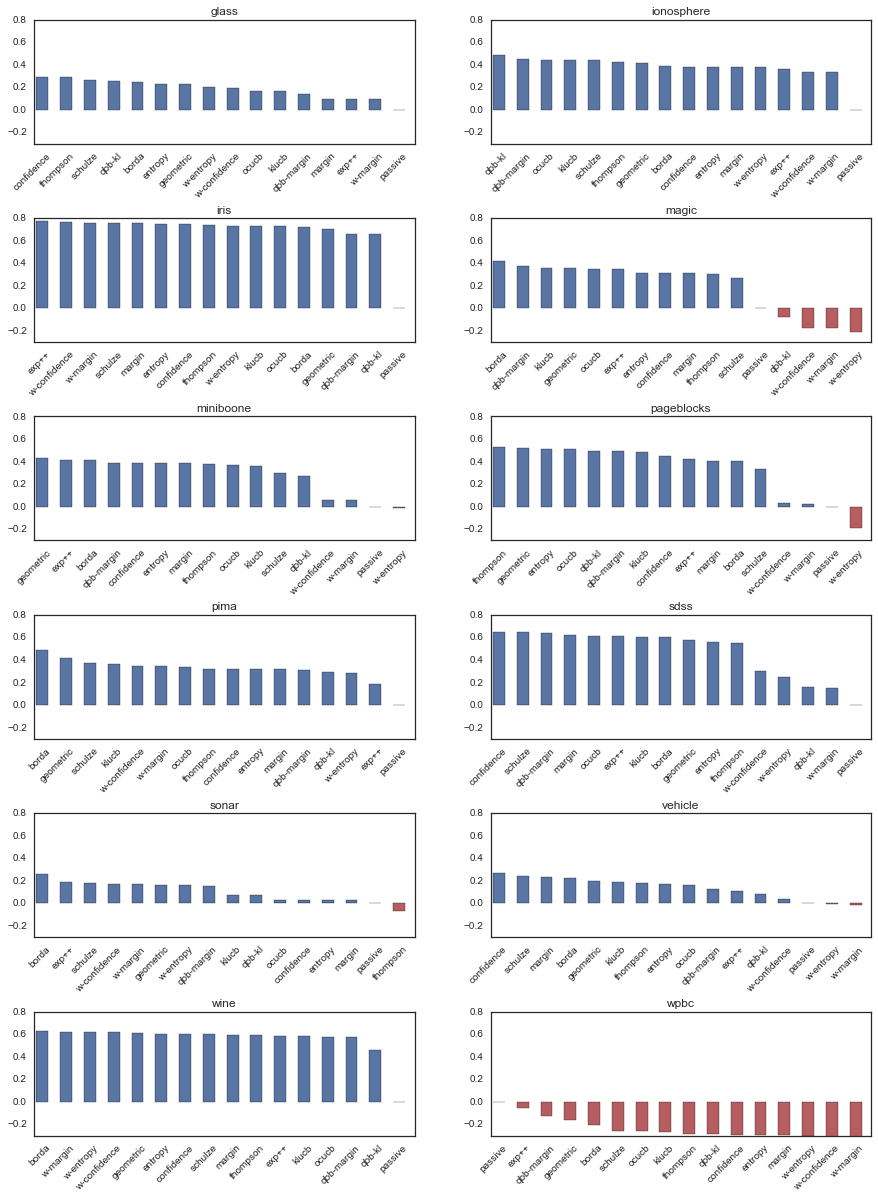

In [9]:
plot_mpba_strength()

In [10]:
def plot_learning_curves():
    selected_methods = ['passive', 'confidence', 'borda', 'exp++']
    format_as_percent_plot = lambda x, pos: "{:.0f}%".format(x * 100)
    fig = plt.figure(figsize=(15, 20))
    for (i, dataset) in enumerate(datasets):
        learning_curves = {}
        for method in selected_methods:
            learning_curves[method] = load_results(dataset, method, 'mpba', True)
        maximum = load_results(dataset, 'max', 'max_mpba')
        sample_size = learning_curves['passive'].shape[0] + 49

        ax = fig.add_subplot(4, 3, i + 1)
        for method in selected_methods:
            xticks = np.arange(50, 50 + len(learning_curves[method]))
            ax.plot(xticks, learning_curves[method], label=method, linewidth=1)

        ax.legend(loc='lower right', frameon=True)
        ax.get_yaxis().set_major_formatter(FuncFormatter(format_as_percent_plot))
        ax.set_title(dataset)
        ax.tick_params(top='off')

        ax.plot([50, sample_size], [maximum, maximum], ls='--', color='#377eb8')
        ax.set_xlim(50, sample_size)
    fig.savefig('learning_curves.pdf', bbox_inches='tight')
    plt.show()

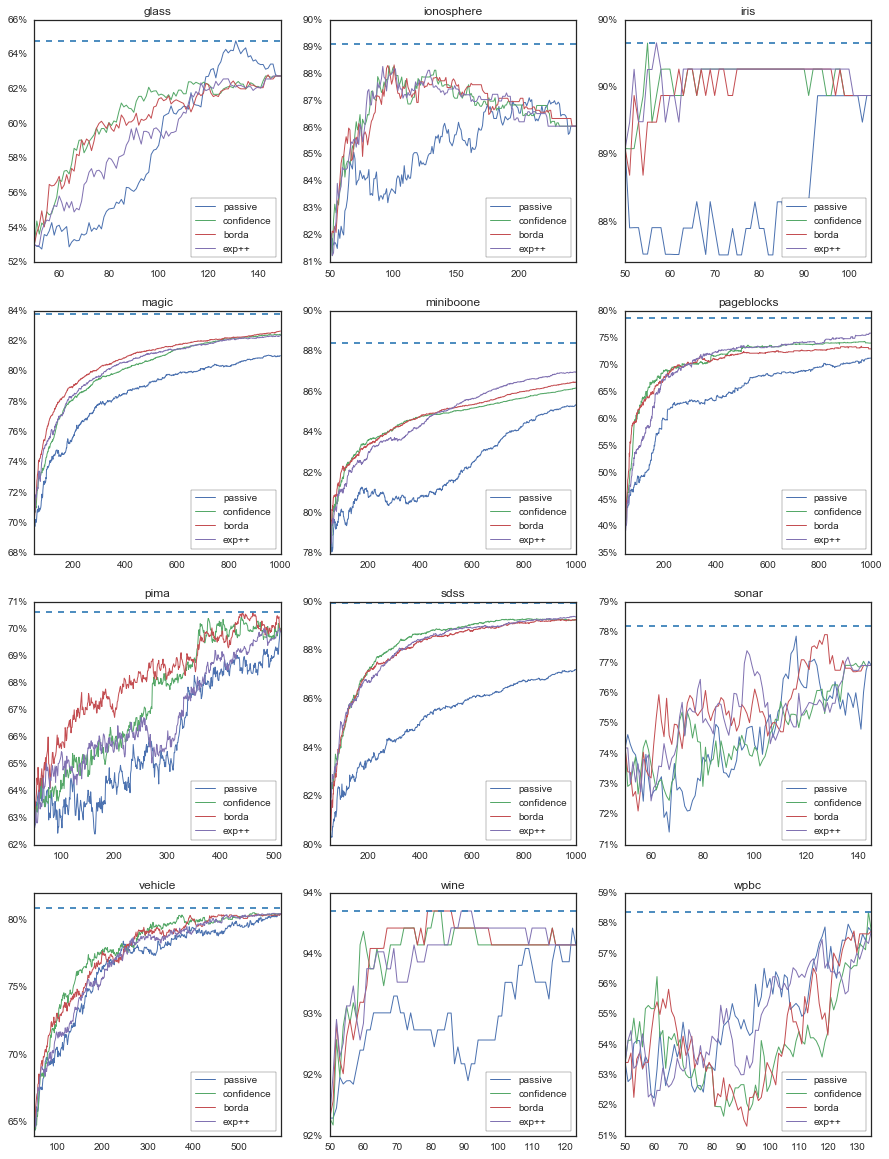

In [11]:
plot_learning_curves()